### Import modul

In [ ]:
import pandas as pd
import json
from NLP_Models import TextMining as tm
from NLP_Models import openewfile as of
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import pickle
from nltk.util import ngrams
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

### Preprocecing Data

In [ ]:
def cleanningtext(data,sentiment = True):
    fSlang = of.openfile(path = './NLP_Models/slangword')
    bahasa = 'id'
    stops, lemmatizer, tokenizer = tm.LoadStopWords(bahasa, sentiment = sentiment)
    sw=open(fSlang,encoding='utf-8', errors ='ignore', mode='r');SlangS=sw.readlines();sw.close()
    SlangS = {slang.strip().split(':')[0]:slang.strip().split(':')[1] for slang in SlangS}

    tqdm.pandas()
    
    data['text'] = data['text'].astype('str')
    data['text'] = data['text'].str.lower()
    data = data[~data.text.str.contains('unavailable')]
    print('------------------------------------------------------------------------------------')
    print('CLEANING DATA TEXT IS PROCESSING')
    data['cleaned_text'] = data['text'].progress_apply(lambda x : tm.cleanText(x,fix=SlangS, pattern2 = True, lang = bahasa, lemma=lemmatizer, tokenizer=tokenizer, stops = stops, symbols_remove = True, numbers_remove = True, hashtag_remove=False, min_charLen = 3))
    print('CLEANING PROCESS IS DONE')
    print('------------------------------------------------------------------------------------')
    print('HANDLING NEGATION IS PROCESSING')
    data['cleaned_text'] = data['cleaned_text'].progress_apply(lambda x : tm.handlingnegation(x))
    print('HANDLING NEGATION IS DONE')
    data = data[data['cleaned_text'].notna()]
    return data

In [ ]:
#preprosecing data
def dataPreparingandProcesing(path_data_negative, path_data_positive):
    with open(f'{path_data_negative}', 'r', encoding='utf-8') as file:
        dataNegative = json.load(file)

    with open(f'{path_data_positive}', 'r', encoding='utf-8') as file:
        dataPositive = json.load(file)

    dfNegative, dfPositive = pd.json_normalize(dataNegative).iloc[0:200], pd.json_normalize(dataPositive).iloc[0:200]
    df = pd.concat([dfNegative,dfPositive])
    df = df[['text', 'Label']]
    df = cleanningtext(df,sentiment = True)
    return df

### Train Model

In [ ]:
def training_models(X_train, X_test, y_train, y_test, vectorizer, model_path, tokenizer_path):
    print('------------------------------------------------------------------------------------')
    print('TRAINING MODEL IS PROCESSING')
    pipeline = Pipeline([
        ('tfidf', vectorizer),
        ('clf', SVC(probability=True))
    ])

    parameters = {
        'clf__C': [1, 10, 100],  # Misalnya, tambahkan lebih banyak nilai atau tambah beberapa hyperparameter lainnya
        'clf__gamma': [0.1, 0.01]  # Misalnya, tambahkan lebih banyak nilai atau tambah beberapa hyperparameter lainnya
    }

    scoring = {
        'accuracy': make_scorer(accuracy_score), #sklearn/matriks
        'precision': make_scorer(precision_score, average='micro', zero_division=1), #ANDA BISA UBAH DISINI (MICRO/MACRO)
        'recall': make_scorer(recall_score, average='micro', zero_division=1), #ANDA BISA UBAH DISINI (MICRO/MACRO)
        'f1_score': make_scorer(f1_score, average='micro', zero_division=1) #ANDA BISA UBAH DISINI (MICRO/MACRO)
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring, cv=5,refit='f1_score', return_train_score=True)
    grid_search.fit(X_train, y_train)
    print('------------------------------------------------------------------------------------')
    print('TRAIN MODEL IS DONE')
    metrics_score_each_fold = pd.DataFrame(grid_search.cv_results_)

    best_model = grid_search.best_estimator_

    print('------------------------------------------------------------------------------------')
    print('EVALUATING MODEL IS PROCESSING')
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print('------------------------------------------------------------------------------------')
    print('EVALUATING MODEL IS DONE')

    with open(f'{model_path}'+'/'+'best_model.pkl', 'wb') as model_file:
        pickle.dump(best_model, model_file)

    with open(f'{tokenizer_path}'+'/'+'tokenizer.pkl', 'wb') as tokenizer_file:
        pickle.dump(vectorizer, tokenizer_file)

    print('------------------------------------------------------------------------------------')
    print('MODEL AND TOKENIZER HAVE BEEN SAVED | ALL PROCESS ARE DONE')
    return {'metrics_train': metrics_score_each_fold, 'best_model_parms': best_model, 'metrics_test': report}

In [ ]:
def matrixtermfreq(data):
    vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.1) #KALIAN HARUS PAHAM MAKSUD DARI max_df dan min_df. Dan boleh kalian ganti parameter ini
    tfs = vectorizer.fit_transform(data)
    feature_names = vectorizer.get_feature_names_out()
    df = pd.DataFrame(tfs.todense(), columns=feature_names)
    return df, vectorizer

### Apply the model

In [ ]:
if __name__ == "__main__":
    path_data_negative, path_data_positive = 'C:/Users/Dell/Desktop/blajar ngoding/datmin baru/DATASET/negative.json', 'C:/Users/Dell/Desktop/blajar ngoding/datmin baru/DATASET/positive.json'
    df = dataPreparingandProcesing(path_data_negative, path_data_positive)

    print('\n'*3)
    print('------------------------------------------------------------------------------------')
    print('Data yang digunakan untuk proses pelatihan dan pengujian')
    print('\n'*1)
    print(df)
    print('------------------------------------------------------------------------------------')

    X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['Label'], test_size=0.2, random_state=42)
    matrixTermFreq =  matrixtermfreq(X_train)
    vectorizer, term_matrix = matrixTermFreq[1], matrixTermFreq[0]
    
    print('\n'*3)
    print('------------------------------------------------------------------------------------')
    print('Term-Matrix hasil TF-IDF')
    print('\n'*1)
    print(term_matrix)
    print('------------------------------------------------------------------------------------')
    
    print('\n'*3)
    training_report = training_models(X_train, X_test, y_train, y_test, vectorizer, 'C:/Users/Dell/Desktop/blajar ngoding/datmin baru/MODEL', 'C:/Users/Dell/Desktop/blajar ngoding/datmin baru/TOKENIZER')

    print('\n'*3)
    print('------------------------------------------------------------------------------------')
    print('MODEL PERFORMANCE ON GRID-SEARCH CV')
    print('\n'*1)
    print(training_report['metrics_train'])
    training_report['metrics_train'].to_csv('C:/Users/Dell/Desktop/blajar ngoding/datmin baru/METRICS/gridSearchcv.csv')
    print('\n'*1)
    print('------------------------------------------------------------------------------------')
    print('BEST MODEL CONFIGURATION')
    print('\n'*1)
    print(training_report['best_model_parms'])
    print('\n'*1)
    print('------------------------------------------------------------------------------------')
    print('MODEL PERFORMANCE ON TEST DATA')
    print('\n'*1)
    print(training_report['metrics_test'])

------------------------------------------------------------------------------------
CLEANING DATA TEXT IS PROCESSING


100%|██████████| 400/400 [00:00<00:00, 1951.54it/s]


CLEANING PROCESS IS DONE
------------------------------------------------------------------------------------
HANDLING NEGATION IS PROCESSING


100%|██████████| 400/400 [00:00<00:00, 80231.53it/s]


HANDLING NEGATION IS DONE




------------------------------------------------------------------------------------
Data yang digunakan untuk proses pelatihan dan pengujian


                                                  text     Label  \
0    kamu tau ga kmaren pas timnas main suporter in...  negative   
1                                     viking anjing!!!  negative   
2          ke 6 viking pernah digigit anjing polisi 😋😁  negative   
3    mentang-mentang goblok gratis diborong semua j...  negative   
4    manusia dijaga daripada bodoh anjing..polis ja...  negative   
..                                                 ...       ...   
195  @thisjwoopuppies bangga banget mau nangiss dia...  positive   
196  seneng banget tl aku penuh sama ucapan jungwoo...  positive   
197  untuk ara dimasa depan, kamu hebat raa bisa sa...  positive   
198  aku bangga sama aku karena berhasil healing, a...  positive   
199  satu lagi, tau nggak kalo kamu tuh hebat bange...  positive   

         

#### K Fold

In [ ]:
#performa model pertama
print(training_report['metrics_test'])

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        44
    positive       1.00      1.00      1.00        36

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
#test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['Label'], test_size=0.2, random_state=42)
#tf idf
matrixTermFreq =  matrixtermfreq(X_train)
vectorizer, term_matrix = matrixTermFreq[1], matrixTermFreq[0]
#classify with SVC
clf = SVC(kernel='linear', C=1, random_state=19, probability=True)
y_train_tfidf = y_train.apply(lambda x: 1 if x == 'positive' else 0)
clf.fit(matrixTermFreq[0], y_train_tfidf)
# CV Score from classify with SVC
scores2 = cross_val_score(clf, matrixTermFreq[0], y_train, cv=5).mean()
scores2

0.98125

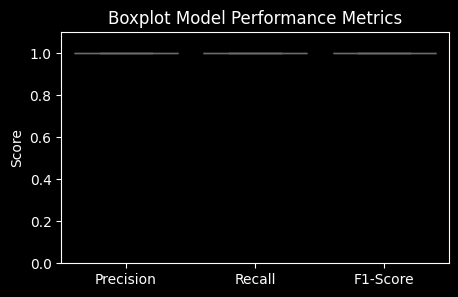

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Hasil performa model
precision_values = [1.00, 1.00]
recall_values = [1.00, 1.00]
f1_score_values = [1.00, 1.00]

# Membuat DataFrame dari hasil performa
data2 = {'Precision': precision_values, 'Recall': recall_values, 'F1-Score': f1_score_values}
data2 = pd.DataFrame(data2)

# Visualisasi dengan boxplot
plt.figure(figsize=(5, 3))
sns.boxplot(data=data2)
plt.title('Boxplot Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Skala sumbu y dari 0 hingga 1.1 untuk memastikan visualisasi yang tepat
plt.show()


### EDA

In [ ]:
term_matrix

,aku,anda,anjing,bangga,hebat,ini,kalau,kalian,kamu,keren,negxsama,nya,sama,saya,semangat,semua,sudah,tidak,viking
0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.192067,0.190648,0.000000,0.000000,0.0,0.487677,0.192067,0.269258,0.000000,0.676392,0.000000,0.349341,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.636571,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.771219
3,0.000000,0.0,0.531182,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.783779,0.000000,0.000000,0.000000,0.000000,0.321769
4,0.180691,0.0,0.000000,0.130254,0.129292,0.381551,0.000000,0.0,0.661457,0.130254,0.000000,0.000000,0.000000,0.000000,0.473827,0.240997,0.225841,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.000000,0.0,0.000000,0.096585,0.287614,0.141462,0.178701,0.0,0.858334,0.096585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167464,0.286171,0.000000
156,0.000000,0.0,0.636571,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.771219
157,0.000000,0.0,0.113817,0.000000,0.000000,0.000000,0.212152,0.0,0.000000,0.000000,0.000000,0.000000,0.403807,0.839710,0.000000,0.212152,0.000000,0.169869,0.000000
158,0.559260,0.0,0.000000,0.201576,0.200087,0.000000,0.000000,0.0,0.511822,0.201576,0.282589,0.313253,0.354940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df = pd.DataFrame(df)
df

,text,Label,cleaned_text
0,kamu tau ga kmaren pas timnas main suporter in...,negative,kamu tahu tidak negxkemarin pas timnas main su...
1,viking anjing!!!,negative,viking anjing
2,ke 6 viking pernah digigit anjing polisi 😋😁,negative,viking pernah gigit anjing polisi
3,mentang-mentang goblok gratis diborong semua j...,negative,mentang mentang goblok gratis borong semua jan...
4,manusia dijaga daripada bodoh anjing..polis ja...,negative,manusia jaga negxdaripada bodoh anjing polis j...
...,...,...,...
95,pas gua peringkat 30 dari 37 di sekolah dia ng...,positive,pas saya peringkat dari sekolah dia bicara beg...
96,tadi pagi laporan hari ini dia nervous huhu ga...,positive,tadi pagi lapor hari ini dia nervous huhu tida...
97,"jaehyun u did well nak, huhu sayang pol sama j...",positive,jaehyun kamu did well anak huhu sayang pol sam...
98,jujur aja sama sekali nggak ada ^__^ pacarku u...,positive,jujur saja sama sekali tidak negxada pacar sud...


In [ ]:
# Tokenisasi teks
df['tokens'] = df['cleaned_text'].apply(word_tokenize)
df['kategori'] = df['Label'].apply(lambda x: 1 if x == 'positive' else 0)
# Pisahkan data berdasarkan kategori (misalnya, kategori 0 dan 1)
kategori_0 = df[df['kategori'] == 0]['tokens']
kategori_1 = df[df['kategori'] == 1]['tokens']

# Hitung frekuensi kata untuk masing-masing kategori
freq_kat_0 = FreqDist([word for tokens in kategori_0 for word in tokens])
freq_kat_1 = FreqDist([word for tokens in kategori_1 for word in tokens])

# Ambil 10 kata dengan frekuensi tertinggi untuk masing-masing kategori
top_10_kat_0 = freq_kat_0.most_common(10)
top_10_kat_1 = freq_kat_1.most_common(10)

print("Top 10 Kata untuk Kategori 0:", top_10_kat_0)
print('\'')
print("Top 10 Kata untuk Kategori 1:", top_10_kat_1)

Top 10 Kata untuk Kategori 0: [('anjing', 111), ('viking', 69), ('tidak', 21), ('bonek', 18), ('saya', 18), ('nya', 13), ('sama', 11), ('anda', 11), ('kalau', 11), ('main', 10)]
'
Top 10 Kata untuk Kategori 1: [('kamu', 156), ('keren', 111), ('hebat', 108), ('bangga', 102), ('aku', 70), ('saya', 50), ('negxsama', 46), ('sudah', 36), ('ini', 35), ('nya', 35)]


In [ ]:
def hitung_ngram(token, n):
    n_gram=ngrams(token, n)
    return FreqDist(n_gram)

In [ ]:
# Hitung frekuensi unigram, bigram, dan trigram untuk masing-masing kategori
freq_unigram_kat_0 = hitung_ngram([word for tokens in kategori_0 for word in tokens], 1)
freq_bigram_kat_0 = hitung_ngram([word for tokens in kategori_0 for word in tokens], 2)
freq_trigram_kat_0 = hitung_ngram([word for tokens in kategori_0 for word in tokens], 3)

freq_unigram_kat_1 = hitung_ngram([word for tokens in kategori_1 for word in tokens], 1)
freq_bigram_kat_1 = hitung_ngram([word for tokens in kategori_1 for word in tokens], 2)
freq_trigram_kat_1 = hitung_ngram([word for tokens in kategori_1 for word in tokens], 3)

# Ambil 10 n-gram dengan frekuensi tertinggi untuk masing-masing kategori
top_10_unigram_kat_0 = freq_unigram_kat_0.most_common(10)
top_10_bigram_kat_0 = freq_bigram_kat_0.most_common(10)
top_10_trigram_kat_0 = freq_trigram_kat_0.most_common(10)

top_10_unigram_kat_1 = freq_unigram_kat_1.most_common(10)
top_10_bigram_kat_1 = freq_bigram_kat_1.most_common(10)
top_10_trigram_kat_1 = freq_trigram_kat_1.most_common(10)

print("Top 10 Unigram untuk Kategori 0:", top_10_unigram_kat_0)
print('/')
print("Top 10 Bigram untuk Kategori 0:", top_10_bigram_kat_0)
print('/')
print("Top 10 Trigram untuk Kategori 0:", top_10_trigram_kat_0)
print('/')

print("Top 10 Unigram untuk Kategori 1:", top_10_unigram_kat_1)
print('/')
print("Top 10 Bigram untuk Kategori 1:", top_10_bigram_kat_1)
print('/')
print("Top 10 Trigram untuk Kategori 1:", top_10_trigram_kat_1)


Top 10 Unigram untuk Kategori 0: [(('anjing',), 111), (('viking',), 69), (('tidak',), 21), (('bonek',), 18), (('saya',), 18), (('nya',), 13), (('sama',), 11), (('anda',), 11), (('kalau',), 11), (('main',), 10)]
/
Top 10 Bigram untuk Kategori 0: [(('viking', 'anjing'), 46), (('anjing', 'bonek'), 6), (('bonek', 'jancok'), 6), (('anjing', 'anjing'), 6), (('anjing', 'viking'), 5), (('bilang', 'viking'), 4), (('tidak', 'negxsemua'), 3), (('jancok', 'viking'), 3), (('anjing', 'lama'), 3), (('anjing', 'kita'), 3)]
/
Top 10 Trigram untuk Kategori 0: [(('viking', 'anjing', 'bonek'), 4), (('anjing', 'bonek', 'jancok'), 4), (('anjing', 'viking', 'anjing'), 4), (('viking', 'anjing', 'viking'), 3), (('bilang', 'viking', 'anjing'), 3), (('bonek', 'jancok', 'viking'), 3), (('jancok', 'viking', 'anjing'), 3), (('viking', 'anjing', 'lama'), 3), (('tidak', 'negxsemua', 'juga'), 2), (('viking', 'anjing', 'saya'), 2)]
/
Top 10 Unigram untuk Kategori 1: [(('kamu',), 156), (('keren',), 111), (('hebat',), 10

In [ ]:
b = test.df[['cleaned_text', 'Label']]
b

NameError: name 'test' is not defined

In [ ]:
b = test.term_matrix
b.twitter.isna().count()

In [ ]:
print(test.training_report['metrics_test'])